# Opinion Detection - Supervised

In [ ]:
import pandas as pd
import numpy as np
import text_normalizer as tn

import nltk
nltk.download('movie_reviews')

import warnings
warnings.filterwarnings('ignore')

### <font color='orange'>Load and Preprocess Data</font>

In [2]:
from nltk.corpus import movie_reviews as mr
from random import shuffle, seed
seed(42)

documents = [(mr.raw(file_id), 1 if category == 'pos' else 0) for category in mr.categories() for file_id in mr.fileids(category)]
shuffle(documents)

In [3]:
df_train, df_test = documents[:1600], documents[1600:]
X_train = [item[0] for item in df_train]
y_train = [item[1] for item in df_train]

X_test = [item[0] for item in df_test]
y_test = [item[1] for item in df_test]

In [4]:
X_train_cleaned = tn.normalize_corpus(X_train)
X_test_cleaned = tn.normalize_corpus(X_test)
pd.DataFrame(X_train_cleaned).to_csv('datasets/X_train_cleaned.csv', index=False)
pd.DataFrame(X_test_cleaned).to_csv('datasets/X_test_cleaned.csv', index=False)

### <font color='orange'>Feature Extraction</font>

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [47]:
# build BOW features on train reviews
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))
cv_train_features = cv.fit_transform(X_train_cleaned)

# transform test reviews into features
cv_test_features = cv.transform(X_test_cleaned)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (1600, 41931)  Test features shape: (400, 41931)


### <font color='orange'>Model Training, Prediction and Performance Evaluation</font>

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#import lightgbm as lgb

In [49]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10]}

lr = LogisticRegression(max_iter = 100, random_state = 42)
lr_grid_search = GridSearchCV(lr, parameters, cv = 10, scoring='accuracy')
lr_grid_search.fit(cv_train_features, y_train)

predictions = lr_grid_search.predict(cv_test_features) 

In [51]:
score = lr_grid_search.score(cv_test_features, y_test)
print("Accuracy score:",np.round(score, 2)*100,"%")

Accuracy score: 84.0 %


Confusion matrix:


Text(0.5, 1.0, 'Accuracy Score: 84.0%')

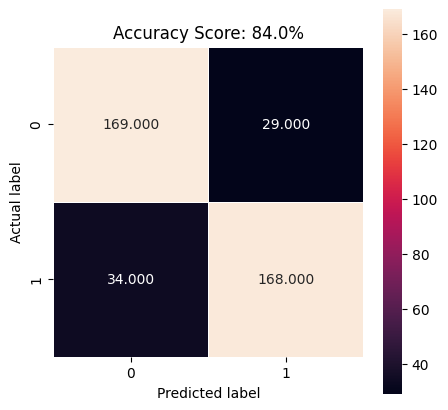

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion matrix:")
all_sample_title = 'Accuracy Score: {0}%'.format(np.round(score,2)*100)
plt.title(all_sample_title, size = 12)